In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# !unzip gdrive/MyDrive/data.zip > /dev/null

# Cat-Dog classification using transfer learning
###### Charlie Rosander 2023-09
A while back I made a Cat-Dog-CNN project, which was a simple CNN model classifying cats and dogs. Running 100 Epochs I would get around 80-85% accuracy, so now I want to try the same dataset but with transfer learning, to see if I can get a better result with fewer epochs etc. We will be using MobileNetV2 as our base model.

The dataset is from Kaggle: https://www.microsoft.com/en-us/download/details.aspx?id=54765

In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV2
import shutil
import pandas as pd

We start by preparing some variables.

In [4]:
# Preparing directory vars
base_dir = os.getcwd() + '/data'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

print(f"""
{base_dir},
{train_dir},
{test_dir}
""")

# Prepare image parameter vars
BATCH_SIZE = 32
IMG_SIZE = (96, 96)



c:\Users\Kaliber\Desktop\AI-Developer-Jensen\AI-kursen\Uppgifter\cat_dog_transferCNN/data,
c:\Users\Kaliber\Desktop\AI-Developer-Jensen\AI-kursen\Uppgifter\cat_dog_transferCNN/data\train,
c:\Users\Kaliber\Desktop\AI-Developer-Jensen\AI-kursen\Uppgifter\cat_dog_transferCNN/data\test



### Data preprocessing
Here we use the ImageDataGenerator to load the images from the directories. I have split the data up into train, val and test in the directories, each with their respective subfolders (cat/dog).

We are also using MobileNetV2's preprocessing method as the preprocessing_function.
ImageDataGenerator automatically labels the images into classes based on the subfolders.

In [5]:
# Preparing the preprocess method
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Create an ImageDataGenerator object with rescaling and validation split
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2  # 20% for validation
)

# Create a test ImageDataGenerator object only with rescaling
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Training data: 80% from train directory
train_gen = train_datagen.flow_from_directory(train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training"  # set as training data
)

# Validation data: 20% from train directory
val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation"  # set as validation data
)

# Test data: Take all images from test directory
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)


Found 16000 images belonging to 2 classes.
Found 3999 images belonging to 2 classes.
Found 4999 images belonging to 2 classes.


### Inspecting the data
We will inspect the data a bit more to see that everything is in order.

In [6]:
# Here we inspect the classes to verify that they are correct.

print("Training class indices:", train_gen.class_indices)
print("Validation class indices:", val_gen.class_indices)
print("Test class indices:", test_gen.class_indices)


Training class indices: {'cat': 0, 'dog': 1}
Validation class indices: {'cat': 0, 'dog': 1}
Test class indices: {'cat': 0, 'dog': 1}


In [7]:
# Inspect batch size and shape
for image_batch, label_batch in train_gen:
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", label_batch.shape)
    break

Image batch shape: (32, 96, 96, 3)
Label batch shape: (32,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


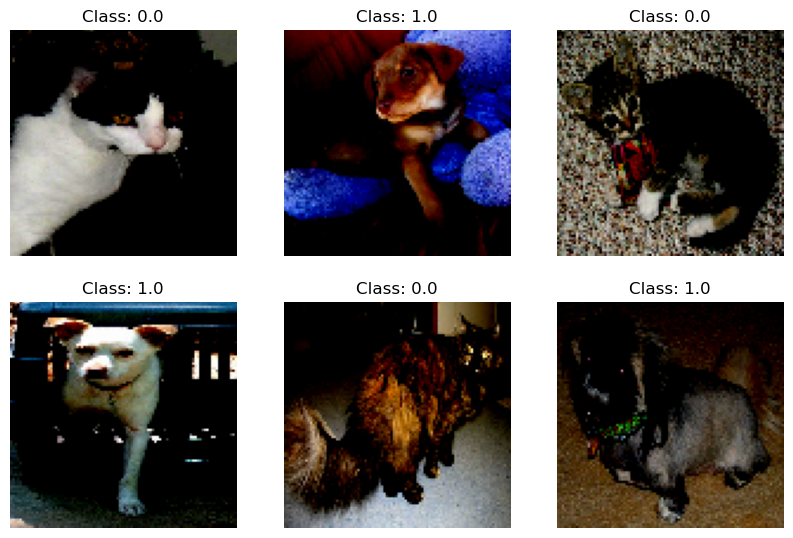

In [8]:
# Inspecting the images. Looks absolutely fantastic. And kinda creepy.
x_batch, y_batch = next(train_gen)

plt.figure(figsize=(10, 10), facecolor='white')
for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f"Class: {y_batch[i]}")
    plt.axis('off')


### Creating the model, using the base model MobileNetV2.
We will use the pretrained model MobileNetV2 as our base model, and we will not include the top layer as we will add our own classifier layer and train it ourselves, as well as freeze the base model so we don't have to retrain it.

In [9]:
# Creating the base model MobileNetV2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [10]:
# # Here we retrieve a batch of images and their labels from train_gen, 
# passes them through the base model to extract the features and then prints the shape

image_batch, label_batch = next(iter(train_gen))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 1280)


In [11]:
# Freezing the base model
base_model.trainable = False

In [12]:
# Inspect the base model
base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 32)   0           ['bn_Conv1[0][0]']               
                                                                                

### Classification head
We need to add a classification head to the model, and we will convert the features to a single 1280-element vector.

In [13]:
# Converting the features to a single 1280-element vector per image

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [14]:
# Adding a prediction layer
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


### Putting it all together
We will now put all the parts together, as well as some last minute data-augmentation because I forgot to write it earlier in the code.

In [15]:
# Some data augmentation
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip(
    'horizontal'), tf.keras.layers.RandomRotation(0.2),])

inputs = tf.keras.Input(shape=(96, 96, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281  

We can see in the output above that we now have 1,281 trainable parameters, which is from the classification head we added. These will be trained, while the base model will be frozen.

In [16]:
# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
# Var for the number of epochs
epoch_num = 5

# Train the actual model
history = model.fit(train_gen, epochs=epoch_num, validation_data=val_gen)

Epoch 1/5
160/500 [========>.....................] - ETA: 1:17 - loss: 0.7687 - accuracy: 0.5525

c:\Users\Kaliber\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


500/500 [==============================] - 150s 291ms/step - loss: 0.5396 - accuracy: 0.7057 - val_loss: 0.2284 - val_accuracy: 0.9027
Epoch 2/5
500/500 [==============================] - 57s 113ms/step - loss: 0.2953 - accuracy: 0.8644 - val_loss: 0.1602 - val_accuracy: 0.9312
Epoch 3/5
500/500 [==============================] - 57s 114ms/step - loss: 0.2467 - accuracy: 0.8896 - val_loss: 0.1387 - val_accuracy: 0.9395
Epoch 4/5
500/500 [==============================] - 56s 112ms/step - loss: 0.2286 - accuracy: 0.9001 - val_loss: 0.1268 - val_accuracy: 0.9452
Epoch 5/5
500/500 [==============================] - 57s 114ms/step - loss: 0.2133 - accuracy: 0.9068 - val_loss: 0.1210 - val_accuracy: 0.9530


### Plotting and evaluation

As we can see in the val_accuracy above, the model is so efficient even with only 5 epochs, 
that the graphs are quite "boring" and doesn't really give us that much information as it is such a short time span.

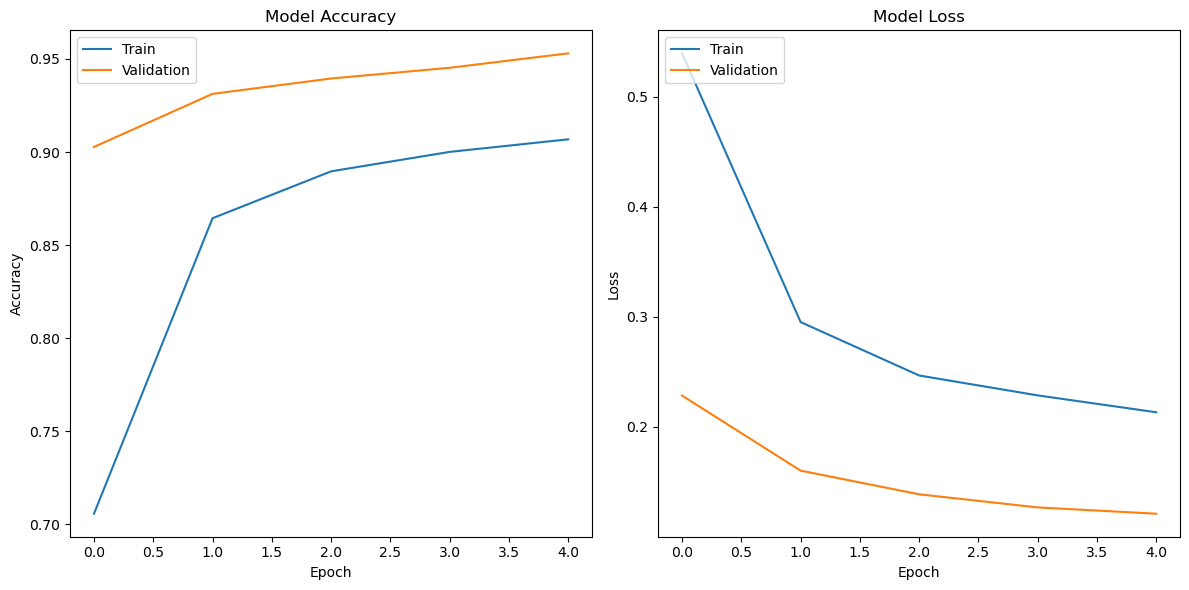

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


### Testing of the model
Here we test the model on the test data which is completely seperate from the training and validation data. We can see that we get almost 95% accuracy after only 5 epochs, which is simply amazing compared to my own model which got around 80-85% after 100 epochs.

In [19]:
# Test the model
test_loss, test_acc = model.evaluate(test_gen, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

157/157 - 37s - loss: 0.1310 - accuracy: 0.9470 - 37s/epoch - 234ms/step

Test accuracy: 0.9469894170761108

Test loss: 0.1310456395149231


# Conclusion

### Dataset

The dataset is the same dataset that I used for my other model. It is a dataset of 25,000 images of cats and dogs, which originally wasn't split up into train/test, so I did that with a script to easier be able to use it in this project with ImageDataGenerator. I split the data into train, validation and test, with 16000 train, 3999 validation and 4999 test images. The reason for the odd val and test numbers is because I noticed that there were corrupted images in the dataset, so I had to make another script identifying and removing those images, like a true hackerman.

### Model

Much of this is covered earlier in the notebook, but to summarize; We use MobileNetV2, freeze the base model and add our own classification head. We are also using ImageDataGenerator to load and label the images from the directories, and we are using MobileNetV2's preprocessing method as the preprocessing_function.

### Results

The results are quite staggering, as this model basically shows over 90% accuracy out of the box on the first epoch, and after 5 epochs we are already at 95% accuracy. 

### Improvements

- Model 
There's not much for me to say about the model itself since it's not my own, and since it's so efficient and accurate.

- Dataset
The dataset is quite large which is good, compared to what I've worked with in past projects. However, when training the model, some kind of wierd message pops up, and I haven't found a solution to it. Searching around tells me that it is most likely a problem with the data, like another corrupted image or the like, which would make sense since I found 2 other corrupted images, but I removed them so it's hard to tell. The program and training still seems to run fine though so I don't know what to make of it.

- Computational load
This is probably the biggest "problem" with this code. The dataset is large, and the model only takes 96x96 as the smallest resolution, so the training time is quite "long". I would like to run this for many more epochs, but for the purpose of this project I don't felt it really necessary to reduce the dataset etc.

- Code
The code could be more structured, and I could have used more functions to make it more readable/efficient, but since this is a demonstrational notebook I felt it was unnecessary, especially since the purpose of this project is to compare this model with my own, much more extensive project.

- Results
As I've praised on and on about, the results are great, but they are not perfect. I don't even know if this is possible to achieve, but I am sure that with more epochs and tinkering with the model and parameters, it would be possible to reach 98-99%.

### Reflections

This has been a very eye-opening project. Seeing both the efficiancy and time-saving of using transfer learning, as well as the amazing results, it almost feels like cheating.
I am amazed at how quickly the model learned to classify the images, and how easy it was to set up. I spent countless hours on my own model, and while im proud of how it performs, it is nothing compared to this.

Of course you can't really compare models side by side like that, and there are many factors that come into play, for example I actually used many more images in this model, due to the fact that I already knew that I would be able to run it for much fewer epochs, but even then I am sure my own model would not be able to perform as well as this one. 
If you are interested in seeing my own model, you can find it here: https://github.com/CharlieRosander/AI-kursen/blob/main/Uppgifter/ImageRecognitionCNN/main.py. 

